In [ ]:
#upload kaggle json
!mkdir /root/.kaggle/
!mv /content/kaggle.json /root/.kaggle/

#download the dataset
!kaggle datasets download -d insaff/massachusetts-roads-dataset

100% 4.71G/4.72G [01:36<00:00, 91.5MB/s]
100% 4.72G/4.72G [01:36<00:00, 52.3MB/s]


In [ ]:
!unzip /content/massachusetts-roads-dataset.zip

In [ ]:
import os
from os import listdir
from datetime import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
import numpy as np
import cv2

In [ ]:
"""There are some missing images in training directory to handle this
deleting the train input images where corresponding output images are missing"""
trainInputImagesPath = '/content/road_segmentation_ideal/training/input'
trainOutputImagesPath = '/content/road_segmentation_ideal/training/output'
testInputImagesPath = '/content/road_segmentation_ideal/testing/input'
testOutputImagesPath = '/content/road_segmentation_ideal/testing/output'

trainInputImagesFiles = listdir(trainInputImagesPath)
trainOutputImagesFiles = listdir(trainOutputImagesPath)
testInputImagesFiles = listdir(testInputImagesPath)
testOutputImagesFiles = listdir(testOutputImagesPath)

for i in trainInputImagesFiles:
  if i not in trainOutputImagesFiles:
    os.remove(trainInputImagesPath+'/'+i)
	
trainInputImagesFiles = listdir(trainInputImagesPath)
trainOutputImagesFiles = listdir(trainOutputImagesPath)
testInputImagesFiles = listdir(testInputImagesPath)
testOutputImagesFiles = listdir(testOutputImagesPath)

print(str(datetime.now()) + ': trainInputImagesFiles:', len(trainInputImagesFiles))
print(str(datetime.now()) + ': trainOutputImagesFiles:',  len(trainOutputImagesFiles))
if(len(trainInputImagesFiles) != len(trainOutputImagesFiles)):
    raise Exception('train input images and output images number mismatch')

print(str(datetime.now()) + ': testInputImagesFiles:', len(testInputImagesFiles))
print(str(datetime.now()) + ': testOutputImagesFiles:', len(testOutputImagesFiles))
if(len(testInputImagesFiles) != len(testOutputImagesFiles)):
    raise Exception('test input images and output images number mismatch')

2021-07-17 12:29:01.921749: trainInputImagesFiles: 804
2021-07-17 12:29:01.921909: trainOutputImagesFiles: 804
2021-07-17 12:29:01.922032: testInputImagesFiles: 13
2021-07-17 12:29:01.922698: testOutputImagesFiles: 13


In [ ]:
"""Path for train and test input, output images as a list"""
image_paths  = [os.path.join(trainInputImagesPath, image_id) for image_id in sorted(os.listdir(trainInputImagesPath))]
output_paths  = [os.path.join(trainOutputImagesPath, image_id) for image_id in sorted(os.listdir(trainOutputImagesPath))]
testimage_paths  = [os.path.join(testInputImagesPath, image_id) for image_id in sorted(os.listdir(testInputImagesPath))]
testoutput_paths  = [os.path.join(testOutputImagesPath, image_id) for image_id in sorted(os.listdir(testOutputImagesPath))]

In [ ]:
img_size = (512, 512)
num_classes = 1
batch_size = 4

**Defining data generator**

In [ ]:
"""class to create image generators in specified batches"""
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

class DatagenaratorF(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
            x[j] = x[j]/255
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="float32")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            y[j] = y[j]/255
            
        return x, y

In [ ]:
"""creation train and validation split"""
import random
# Split our img paths into a training and a validation set
val_samples = 50
random.Random(1000).shuffle(image_paths )
random.Random(1000).shuffle(output_paths)
train_input_img_paths = image_paths[:-val_samples]
train_target_img_paths = output_paths[:-val_samples]
val_input_img_paths = image_paths[-val_samples:]
val_target_img_paths = output_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = DatagenaratorF(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = DatagenaratorF(batch_size, img_size, val_input_img_paths, val_target_img_paths)

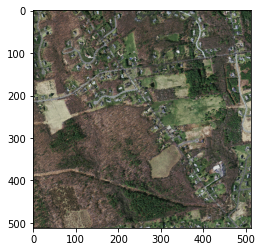

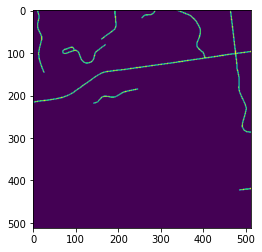

In [ ]:
#View the input image and its actual output
test_gen = DatagenaratorF(
    1, img_size, image_paths, output_paths
)
xt,yt = test_gen.__getitem__(1)
plt.imshow(xt[0])
plt.show()

plt.imshow(yt[0,:,:,0])
plt.show()

In [ ]:
#https://segmentation-models.readthedocs.io/en/latest/ the model used from
!pip install segmentation-models

In [ ]:
# next series of code from https://github.com/qubvel/segmentation_models/blob/master/examples/binary%20segmentation%20(camvid).ipynb
import segmentation_models as sm
BACKBONE = 'efficientnetb5'
BATCH_SIZE = batch_size
CLASSES = ['road']
LR = 0.000001
EPOCHS = 40
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
# define network parameters
sm.set_framework('tf.keras')
sm.framework()
#create model
model = sm.Unet(BACKBONE,encoder_weights = 'imagenet',encoder_freeze=False) # add encoder_weights next time imagenet

115515392/115515256 [==============================] - 2s 0us/step


In [ ]:
optim = keras.optimizers.Adam()
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
model.compile(optim, loss = bce_jaccard_loss, metrics = [iou_score,'accuracy'])

**Callbacks**

In [ ]:
from keras.callbacks import EarlyStopping

from keras.callbacks import ModelCheckpoint

mode_autosave = ModelCheckpoint("./weights/road_crop."+BACKBONE+"imgsize.h5",monitor='val_iou_score', 
                                   mode = 'max', save_best_only=True, verbose=1, save_freq ='epoch')
early_stopping= EarlyStopping(patience = 15,verbose = 1,mode='auto',restore_best_weights=True)

callbacks = [   mode_autosave,
    keras.callbacks.ReduceLROnPlateau(monitor = 'val_iou_score',
                                      factor=0.1,
                               cooldown= 10,
                               patience=10,verbose =1,
                               min_lr=0.1e-5),early_stopping]

In [ ]:
#tf.config.run_functions_eagerly(True)
history = model.fit_generator(
    train_gen, 
    epochs=EPOCHS,
    shuffle =True,
    callbacks=callbacks, 
    validation_data=val_gen,verbose = 1,use_multiprocessing = True,workers=6)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
188/188 [==============================] - 246s 992ms/step - loss: 0.8308 - iou_score: 0.3335 - val_loss: 0.8698 - val_iou_score: 0.2896

Epoch 00001: val_iou_score improved from -inf to 0.28964, saving model to ./weights/road_crop.efficientnetb5imgsize.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/40
188/188 [==============================] - 189s 982ms/step - loss: 0.6368 - iou_score: 0.4801 - val_loss: 0.8823 - val_iou_score: 0.3427

Epoch 00002: val_iou_score improved from 0.28964 to 0.34269, saving model to ./weights/road_crop.efficientnetb5imgsize.h5
Epoch 3/40
188/188 [==============================] - 187s 980ms/step - loss: 0.6035 - iou_score: 0.5096 - val_loss: 0.6793 - val_iou_score: 0.4404

Epoch 00003: val_iou_score improved from 0.34269 to 0.44043, saving model to ./weights/road_crop.efficientnetb5imgsize.h5
Epoch 4/40
188/188 [==============================] - 185s 968ms/step - loss: 0.5805 - iou_score: 0.5281 - val_loss: 0.5702 - val_iou_score: 0.5332

Epoch 00004: val_iou_score improved from 0.44043 to 0.53321, saving model to ./weights/road_crop.efficientnetb5imgsize.h5
Epoch 5/40
188/188 [==============================] - 185s 970ms/step - loss: 0.5655 - iou_score: 0.5409 - val_loss: 0.5779 - val_iou_score: 0.5335

Epoch 00005: val_iou_score improved fr

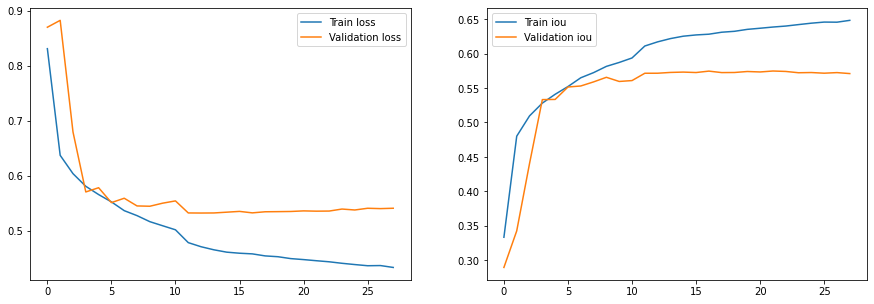

In [ ]:
def plot_training_history(history):
    """
    Plots model training history 
    """
    fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
    ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
    #ax_loss.set_ylim([0,3])
    ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax_loss.legend()
    ax_acc.plot(history.epoch, history.history["iou_score"], label="Train iou")
    ax_acc.plot(history.epoch, history.history["val_iou_score"], label="Validation iou")
    ax_acc.legend()
plot_training_history(history)

**Overall Performance**

In [ ]:
test_generator = DatagenaratorF(1, img_size, testimage_paths, testoutput_paths)
scores = model.evaluate(test_generator)
print("Loss: {:.5}".format(scores[0]))
print("iou_score: {:.5}".format(scores[1]))
print("Accuracy: {:.5}".format(scores[2]))

13/13 [==============================] - 2s 110ms/step - loss: 0.5970 - iou_score: 0.5476 - accuracy: 0.9628
Loss: 0.59697
iou_score: 0.54761
Accuracy: 0.96278


In [ ]:
test_generator = DatagenaratorF(13, img_size,testimage_paths, testoutput_paths)
test_preds = model.predict(test_generator)

(-0.5, 511.5, 511.5, -0.5)

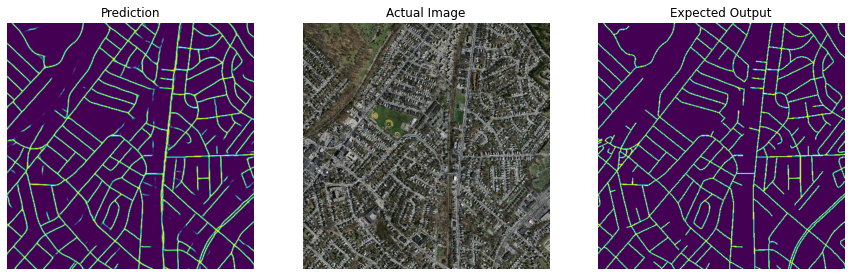

In [56]:
i =11
fig, (ax_pred, ax_act,ax_exp) = plt.subplots(1, 3, figsize=(15,5))
ax_pred.imshow(test_preds[i,:,:,0])
ax_pred.title.set_text('Prediction')
ax_pred.axis('off')
ax_act.imshow(xt[i])
ax_act.title.set_text('Actual Image')
ax_act.axis('off')
ax_exp.imshow(yt[i,:,:,0])
ax_exp.title.set_text('Expected Output')
ax_exp.axis('off')